# Chap2. 자연어와 단어의 분산 표현
## 2.4 통계 기반 기법 개선하기

앞 절에서 생성한 동시 발생 행렬(co-occurence matrix) 개선 및 실용적인 말뭉치를 사용한 '진짜'단어의 분산 표현 구현하기

### 2.4.1 상호정보량

앞서 살펴본 co-occurence matrix에서 행렬의 원소는 두 단어가 동시에 발생한 횟수를 나타낸다. 그러나 이 '발생 횟수'는 사실 그리 좋은 특징이 아니다.

문서에서 'the car'라는 문구가 자주보인다.그렇다면 'the'와 'car'의 동시 발생 횟수 또한 높을 것이다.<br>
한편 'car'와 'drive'는 확실히 관련이 깊다. 하지만 단순 등장 횟수(동시 발생 횟수 등)만 보면 'car'는 'drive'보다는 'the'와의 관련성이 훨씬 강하다고 나올 것이다.

이 문제를 해결하기 위해 점별 상호정보량(Pointwise Mutual Information(PMI))라는 척도를 사용한다.<br>
(확률에 관해서는 3.5.1 CBOW 모델과 확률 절에서 자세히 설명한다)

In [1]:
# library import

import numpy as np

In [2]:
## Do-it common/utils ppmi()

def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i,j] * N / (S[j]*S[i]) + eps)  # ??
                                                           # S[j] 전체 corpus에서 j가 발생한 횟수
                                                           # C(j)
                                                           # S[i]도 마찬가지이다.
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%%완료' % (100*cnt/total))


---
Break! common/utils.py 구현하고 오기 

---

In [3]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi

text = 'You say goodbye and I say hello'
corpus, wor_to_id, id_to_word = preprocess(text)
vocab_size = len(wor_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print('동시 발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시 발생 행렬
[[0 1 0 0 0 0]
 [1 0 1 0 1 1]
 [0 1 0 1 0 0]
 [0 0 1 0 1 0]
 [0 1 0 1 0 0]
 [0 1 0 0 0 0]]
--------------------------------------------------
PPMI
[[0.    1.585 0.    0.    0.    0.   ]
 [1.585 0.    0.585 0.    0.585 1.585]
 [0.    0.585 0.    1.585 0.    0.   ]
 [0.    0.    1.585 0.    1.585 0.   ]
 [0.    0.585 0.    1.585 0.    0.   ]
 [0.    1.585 0.    0.    0.    0.   ]]


왜때문에 PPMI 출력값이 None로 나오는거지??<br>
==> 수정 완료 -20.03.22.am 00:26-

* PPMI(Positive Pointwise Mutual Information)행렬의 문제점
    * 1. 말뭉치의 어휘 수가 증가함에 따라 각 단어 벡터의 차원 수도 증가한다는 문제가있다.
    * 2. 원소 대부분이 0이다. 
        * 이는 벡터 원소 대부분이 중요하지 않다는 뜻이다.
        * 각 원소의 '중요도'가 낮다는 뜻이다.
        * 이런 벡터는(중요도가 낮은 벡터) 노이즈에 약하고 견고하지 못하다는 약점이 있다.
        * 이 문제를 해결하고자 수행하는 기법이 바로 **벡터의 차원 감소**이다.

### 2.4.2 차원 감소

* 차원 감소(Dimensionality Reduction)는 문자 그대로 벡터의 차원을 줄이는 방법을 말한다. 
    * 여기서 중요한 점은 단순히 차원을 줄이는 것이 아니라, '중요한 정보'는 최대한 유지하면서 줄이는 게 핵심이다.
    * 직관적인 예로는 데이터의 분포를 고려해 중요한 '축'을 찾는 일을 수행하는 것이 있다.

[X][To-do] ===== 그림 첨부 -- 2차원 데이터 1차원 표현 -- ====

* 차원 감소의 핵심
    * 차원 감소의 핵심은 '    '이다.<br>
    => 차원 감소의 핵심은 Sparse Matrix(or Sparse Vector)(희소 행렬 또는 희소 벡터)에서 중요한 축을 찾아내어 더 적은 차원으로 다시 표현하는 것이다.<br>
    * 차원 감소 결과 원래의 희소벡터는 원소 대부분이 0이 아닌 값으로 구성된 '밀집벡터'로 변환된다.

차원 감소 방법에는 여러 방법이 있지만 우선은 SVD(Singular Value Decomposition)을 이용한다.

### 2.4.3 SVD에 의한 차원 감소

SVD를 파이썬 코드로 살펴보자.<br>
SVD는 넘파이의 linalg 모듈이 제공하는 svd 메서드로 실행할 수 있다.

동시 발생 행렬(co-occurunce matrix)를 만들어 PPMI행렬로 변환한 다음 SVD를 적용해보도록하자.

In [6]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi

text = 'You say goodbye and I say hello'
corpus, wor_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)  # NumPy linalg모듈의 svd메서드

In [8]:
print(C[0])  # 동시 발생 행렬

print(W[0])  # PPMI 행렬

print(U[0])  # SVD
             # 이 코드에서 SVD에 의해 변환된 밀집벡터 표현은 변수 U에 저장된다.

[0 1 0 0 0 0]
[0.    1.585 0.    0.    0.    0.   ]
[-0.452  0.     0.    -0.543  0.183 -0.683]


결과에서 볼 수 있듯이 원래의 희소벡터인 W[0]가 SVD에 의해 밀집벡터U[0]로 변했다.

그리고 이 밀집벡터의 차원을 감소시키려면, 예컨데 2차원 벡터로 줄이려면 단순히 처음의 두 원소를 꺼내면 된다.

In [10]:
print(U[0, :2])

[-0.452  0.   ]


각 단어를 2차원 벡터로 표현한 후 그래프로 그려보자

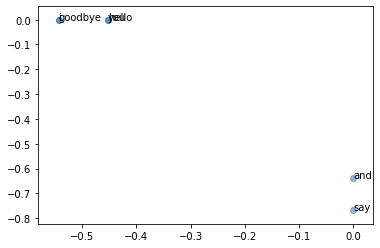

In [13]:
# SVD에 의해 각 단어들을 2차원 벡터로 표현한다
# 2차원 벡터값을 그래프로 확인해보자.

for word, word_id in wor_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    
plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()

goodbye와 hello 그리고 and와 say가 비슷한 단어로 분류되고 있다.<br>
corpus의 크기가 아직은 작기 때문에 더 큰 데이터 셋(말뭉치)을 활용하여 실험을 해 볼 필요가 있다. 

### 2.4.4 PTB 데이터셋

이제 '본격적인'말뭉치를 가지고 실험을 해보자. **펜 트리뱅크(Penn Treebank(PTB))** Corpus를 활용해 실험을 해보자.

### 2.4.5 PTB 데이터셋 평가